# Saving umaps in original space

In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data
from torch.utils.data import ConcatDataset

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.fitters.p_unet_fitter import PUNetLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.run.model_load.load_ssn import load_ssn
from trustworthai.run.model_load.load_punet import load_p_unet
from trustworthai.run.model_load.load_deterministic import load_deterministic
from trustworthai.models.stochastic_wrappers.ssn.LowRankMVCustom import LowRankMultivariateNormalCustom
from trustworthai.models.stochastic_wrappers.ssn.ReshapedDistribution import ReshapedDistribution

# optimizer and lr scheduler
import torch

# misc
import argparse
import os
import shutil
import shlex
from collections import defaultdict
from tqdm import tqdm
import sys
from natsort import natsorted

print("banana")

strawberry
banana


In [2]:
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever

In [3]:
models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"

In [4]:
def construct_parser():
    parser = argparse.ArgumentParser(description = "train models")
    
    # folder arguments
    parser.add_argument('--ckpt_dir', default='s2208943/results/revamped_models/', type=str)
    parser.add_argument('--model_name', default=None, type=str)
    
    # data generation arguments
    parser.add_argument('--dataset', default='ed', type=str)
    parser.add_argument('--seed', default=3407, type=int)
    parser.add_argument('--test_split', default=0.15, type=float)
    parser.add_argument('--val_split', default=0.15, type=float)
    parser.add_argument('--empty_slice_retention', default=0.1, type=float)
    
    # model specific parameters SSN
    parser.add_argument('--ssn_rank', default=15, type=int)
    parser.add_argument('--ssn_epsilon', default=1e-5, type=float)
    parser.add_argument('--ssn_mc_samples', default=10, type=int)
    parser.add_argument('--ssn_sample_dice_coeff', default=0.05, type=float)
    parser.add_argument('--ssn_pre_head_layers', default=16, type=int)
    
    # evidential loss parameters
    parser.add_argument('--kl_factor', default=0.1, type=float)
    parser.add_argument('--kl_anneal_count', default=452*4, type=int)
    
     # model specific parameters Punet
    parser.add_argument('--kl_beta', default=10.0, type=float)
    parser.add_argument('--use_prior_for_dice', default=False, type=bool)
    parser.add_argument('--punet_sample_dice_coeff', default=0.05, type=float)
    parser.add_argument('--latent_dim', default=12, type=int)
    
    # general arguments for the loss function
    parser.add_argument('--dice_factor', default=5, type=float)
    parser.add_argument('--xent_factor', default=0.01, type=float)
    parser.add_argument('--dice_empty_slice_weight', default=0.5, type=float)
    
    # general arguments for the loss function
    parser.add_argument('--loss_name', default='dice+xent', type=str)
    # parser.add_argument('--dice_factor', default=5, type=float)
    # parser.add_argument('--xent_factor', default=0.01, type=float)
    parser.add_argument('--xent_weight', default='none', type=str)
    #parser.add_argument('--dice_empty_slice_weight', default=0.5, type=float)
    parser.add_argument('--tversky_beta', default=0.7, type=float)
    parser.add_argument('--reduction', default='mean_sum', type=str)
    
    # training paradigm arguments
    parser.add_argument('--lr', default=2e-4, type=float)
    parser.add_argument('--dropout_p', default=0.0, type=float)
    parser.add_argument('--max_epochs', default=100, type=int)
    parser.add_argument('--early_stop_patience', default=15, type=int)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--cross_validate', default=False, type=bool)
    parser.add_argument('--cv_split', default=0, type=int)
    parser.add_argument('--cv_test_fold_smooth', default=1, type=int)
    parser.add_argument('--weight_decay', default=0.0001, type=float)
    parser.add_argument('--overwrite', default=False, type=bool)
    
    return parser

In [5]:
def load_best_checkpoint(model, loss, model_ckpt_folder, punet=False):
    # this is ultimately going to need to be passed a model wrapper when I implement P-Unet....
    
    # the path to the best checkpoint is stored as a single line in a txt file along with each model
    with open(os.path.join(model_ckpt_folder, "best_ckpt.txt"), "r") as f:
        ckpt_file = os.path.join(model_ckpt_folder, f.readlines()[0][:-1].split("/")[-1])
    
    if punet:
        return PUNetLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)
    return StandardLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)

In [6]:
def entropy_map_from_mean(mean, do_normalize=True):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    if mean.shape[1] == 1:
        raise ValueError("not implemented for implicit background class")
    else:
        assert mean.shape[1] == 2
    
    if do_normalize:
        probs = torch.nn.functional.softmax(mean, dim=1)
    else:
        probs = mean
    ent_map = torch.sum(-probs * torch.log(probs+1e-30), dim=1)

    return ent_map

In [7]:
def generate_means_and_samples_SSN(splits=6, dataset_stride=2, temp=1, num_samples=10, independent=False, use_updated_scores=False):
    # load data
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    
    rank = 15
    if independent:
        rank = 1
    
    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":rank,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    if independent:
        model_base_name = "ssn_ind_32_cross_validate_"
    else:
        model_base_name = "ssn_cross_validate_32_"
    ensemble_element = 0

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
            
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        if independent:
            model_name = model_base_name + f"split{split}/"
        else:
            model_name = model_base_name + f"split{split}_ens{ensemble_element}/"
        model_path = models_folder + model_name

        model = load_best_checkpoint(model_raw, loss, model_path)
        model.eval()

        dataskip = dataset_stride
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0]
                with torch.no_grad():
                    mean, sample = model.mean_and_sample(x.swapaxes(0,1).cuda(), num_samples=num_samples, temperature=temp)
                    means.append(mean.cpu())
                    samples.append(sample.cpu())

    return means, samples, ConcatDataset(test_datasets)

In [8]:
import matplotlib.pyplot as plt
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples
from trustworthai.utils.plotting.saving_plots import save, imsave
from trustworthai.utils.print_and_write_func import print_and_write
import pandas as pd

In [9]:
save_folder = "test_clinscores/results/"
results_file = save_folder + "text_results.txt"

try:
    os.mkdir(save_folder)
    os.mkdir(save_folder + "/images")
except:
    pass

with open(results_file, "w") as f:
    print_and_write(results_file, "begin results")

begin results


In [10]:
stride = 1

In [12]:
means, samples, test_datasets = generate_means_and_samples_SSN(splits=6, dataset_stride=stride, temp=1, num_samples=10, use_updated_scores=False)

size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:25<00:00,  1.62it/s]


size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:10<00:00,  4.12it/s]


size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:10<00:00,  4.13it/s]


size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:10<00:00,  4.14it/s]


size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:10<00:00,  4.13it/s]


size:  40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.48it/s]


In [13]:
len(means), len(samples)

(250, 250)

In [14]:
# softmax entropy
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=True) for scan_index in range(len(means))]

# evidential
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=False) for scan_index in range(len(means))]

# other methods
ent_maps = [entropy_map_from_samples(samples[scan_index]) for scan_index in range(len(means))]

In [15]:
samples[0].shape

torch.Size([10, 40, 2, 224, 160])

In [16]:
len(test_datasets), len(test_datasets[0])

(250, 3)

In [23]:
dataset = test_datasets

In [17]:
xs3d_test = []
ys3d_test = []
IDs = []
clin_values = []

for i, data in enumerate(test_datasets):
    if i % stride == 0:
        ys3d_test.append(data[1].squeeze())
        xs3d_test.append(data[0])
        IDs.append(data[-1]['ID'])
        clin_values.append(data[-1])

In [18]:
clin_values = pd.DataFrame.from_records(clin_values)

In [19]:
len(xs3d_test)

250

In [20]:
def plot_example(save_dir, test_datasets, means, ent_maps, scan_index, slice_index=25, stride=1):
    plt.imshow(test_datasets[scan_index * stride][0][0][slice_index],
           cmap='gray',
           vmin=None, vmax=None, origin='lower')
    plt.axis('off')
    save(save_dir, f"flair_{scan_index}_{slice_index}", is_img=True)
    
    plt.imshow(test_datasets[scan_index * stride][1][0][slice_index],
           cmap='gray',
           vmin=None, vmax=None, origin='lower')
    plt.axis('off')
    save(save_dir, f"GT_{scan_index}_{slice_index}", is_img=True)
    
    plt.imshow(means[scan_index][slice_index].argmax(dim=0),
           cmap='gray',
           vmin=None, vmax=None, origin='lower')
    plt.axis('off')
    save(save_dir, f"mean_{scan_index}_{slice_index}", is_img=True)
    
    plt.imshow(ent_maps[scan_index][slice_index],
           cmap='magma',
           vmin=0, vmax=0.7, origin='lower')
    plt.axis('off')
    save(save_dir, f"umap_{scan_index}_{slice_index}", is_img=True)

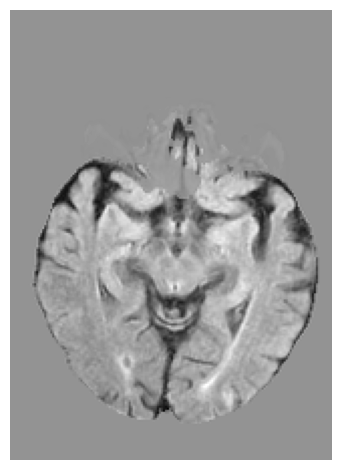

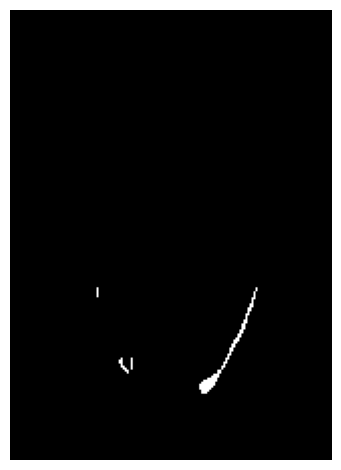

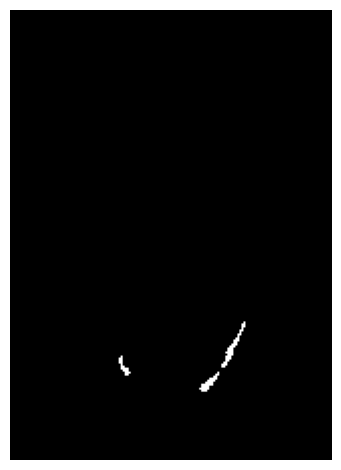

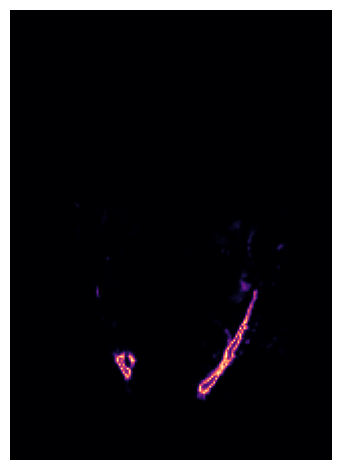

In [21]:
plot_example(save_folder, test_datasets, means, ent_maps, 87, 15)

### generate the comb maps

In [44]:
comb_maps = []
for i in tqdm(range(len(ent_maps)), position=0, leave=True):
    umap = ent_maps[i].cuda().clone()
    umap[means[i].cuda().argmax(dim=1) == 1] = max_ent
    comb_maps.append(umap.cpu())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:09<00:00, 26.48it/s]


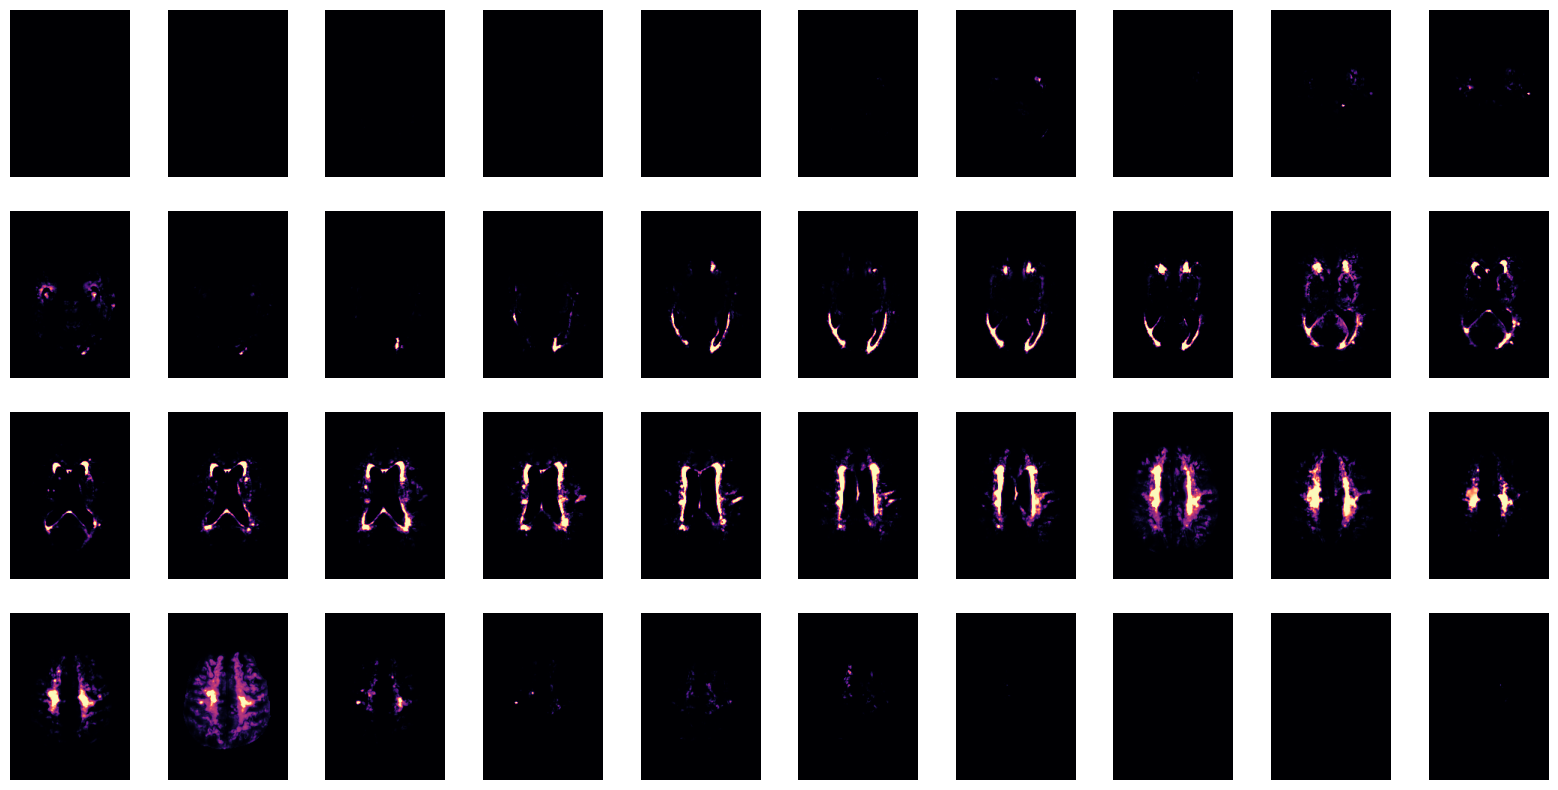

In [45]:
# plot the entropy map for the first brain scan all slices
plt.figure(figsize=(20, 10))
for i, img in enumerate(comb_maps[0]):
    plt.subplot(4, 10, i+1)
    plt.imshow(img, vmin=0, vmax=0.7, cmap='magma', origin='lower')
    plt.axis('off')

### aux code for loading fast files

In [46]:
import torchvision as tv
from twaidata.MRI_preprep.resample import resample_and_return, get_resampled_img
from natsort import natsorted
import nibabel as nib
from collections import defaultdict

In [47]:
fast_folder = "/home/s2208943/ipdis/data/preprocessed_data/Ed_fast_WM_masks/"

In [48]:
# output of fast results:
# we have to resample the image first
fnames = [name for name in natsorted(os.listdir(fast_folder)) if (".nii.gz" in name and "_T1_BET_" in name and ("pveseg" in name or "pve_2" in name))]
fnames = natsorted(fnames)

In [49]:
############################################## Function for resampling an image ###########################################################

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.], original_spacing=None):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing=out_spacing, original_spacing=original_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

### Converting the uncertainty maps back to the original shape for maria

In [135]:
import SimpleITK as sitk
import math
import nibabel as nib

In [51]:
# individual example
pos = 8
ID = IDs[pos]
num_slices = dataset[pos][0].shape[1]

sel_files = [f for f in natsorted(os.listdir(fast_folder)) if ID in f and "_T1_BET_" in f]

In [52]:
sel_files

['CVD052_T1_BET_mixeltype.nii.gz',
 'CVD052_T1_BET_pve_0.nii.gz',
 'CVD052_T1_BET_pve_1.nii.gz',
 'CVD052_T1_BET_pve_2.nii.gz',
 'CVD052_T1_BET_pveseg.nii.gz',
 'CVD052_T1_BET_seg.nii.gz']

In [53]:
example_wm = fast_folder + sel_files[3]
orig_img = sitk.ReadImage(example_wm)
orig_spacing = orig_img.GetSpacing()
orig_shape = sitk.GetArrayFromImage(orig_img).shape
orig_channels = orig_shape[0]
sel_files[3]

prepped_img = ent_maps[pos]
prepped_channels = prepped_img.shape[0]

In [54]:
orig_spacing, orig_shape

((0.9375, 0.9375, 3.9999868869781494), (30, 256, 256))

In [255]:
def reverse_resampling_of_image(flair_file, img_to_resample, save_location=None, name=None):
    # load the flair file that is in the target shape  and sampling
    orig_img = sitk.ReadImage(flair_file)
    orig_spacing = orig_img.GetSpacing()
    orig_shape = sitk.GetArrayFromImage(orig_img).shape
    
    resampled_orig = resample_and_return(flair_file, is_label=True)
    resampled_slice_num = resampled_orig.shape[0]
    
    # get the un padded shape of the resampled version of the original image shape
    timg = resample_and_return(flair_file, is_label=True)
    timg = torch.Tensor(timg)
    h_orig, w_orig = timg.shape[1:]
    
    # perform padding
    h, w = img_to_resample.shape[1:]
    h_diff = (h_orig - h) // 2
    w_diff = (w_orig - w) // 2
    new_img = torch.nn.functional.pad(img_to_resample, pad=(w_diff, w_diff, h_diff, h_diff), mode='constant', value=0)
    
    # do channel interpolation
    #print(orig_shape)
    new_img = torch.nn.functional.interpolate(new_img.unsqueeze(0).unsqueeze(0), (resampled_slice_num, *new_img.shape[1:])).squeeze()
    
    # convert to int16
    new_img = np.array(new_img*32767, dtype=np.int16)
    # print(np.unique(new_img))
    
    # resample
    new_img = sitk.GetImageFromArray(new_img)
    new_img.SetSpacing([1., 1., 3.]) # the spacing that was used as the out spacing during the preprocessing stage
    # we need to tell the sitk image what the true spacing prior to resampling is because it doesn't know as its just taken from a numpy array
    new_img = get_resampled_img(new_img, is_label=True, out_spacing=orig_spacing)
    
    #print("direction: ", new_img.GetDirection(), orig_img.GetDirection())
    new_img.SetDirection(orig_img.GetDirection())
    #print(new_img.GetSpacing())
    
    if save_location:
        save_path = f"{save_location}{name}.nii.gz"
        sitk.WriteImage(new_img, save_path)
        
        # adjust the nifti file fields
        flair = nib.load(flair_file)
        new_img = nib.load(save_path)
        new_img = nib.nifti1.Nifti1Image(new_img.dataobj[:], flair.affine, flair.header)
        
        # the one line above does all of the below, and fixes pixdim4
        #new_img.header.set_xyzt_units(*flair.header.get_xyzt_units())
        # new_img.set_sform(flair.get_sform())
        # new_img.set_qform(flair.get_qform())
        
        nib.save(new_img, save_path)
        
    else:
        return new_img

In [278]:
max_ent = -math.log(0.5)

for pos in tqdm(range(len(xs3d_test)), position=0, leave=True):
    ID = clin_values.iloc[pos]['ID']
    wm_path = fast_folder + ID + "_T1_BET_pve_2.nii.gz"
    flair_path = f'/home/s2208943/ipdis/data/core_data/EdData/{ID}/MRI/FLAIR.nii.gz'
    result_dir = "/home/s2208943/ipdis/data/preprocessed_data/EdData_umaps/ssn/"
    
    
    mask = xs3d_test[pos][1]
    # just ensure it never goes above 1 when rescaling (so we dont get problems
    # when converting to int16
    ent = torch.minimum((ent_maps[pos] / max_ent) * mask, torch.Tensor([1]))
    comb = torch.minimum((comb_maps[pos] / max_ent) * mask, torch.Tensor([1]))
    seg = torch.nn.functional.softmax(means[pos], dim=1)[:,1] * mask
    
    reverse_resampling_of_image(flair_path, ent, result_dir, ID + "_ent_map")
    reverse_resampling_of_image(flair_path, comb, result_dir, ID + "_comb_map")
    reverse_resampling_of_image(flair_path, seg, result_dir, ID + "_seg_map")
    
    # break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [08:36<00:00,  2.07s/it]


In [271]:
f'/home/s2208943/ipdis/data/core_data/EdData/{ID}/MRI/FLAIR.nii.gz', result_dir + ID + "_comb_map.nii.gz"

('/home/s2208943/ipdis/data/core_data/EdData/CVD152/MRI/FLAIR.nii.gz',
 '/home/s2208943/ipdis/data/preprocessed_data/EdData_umaps/ssn/CVD152_comb_map.nii.gz')

In [272]:
img = sitk.ReadImage(f'/home/s2208943/ipdis/data/core_data/EdData/{ID}/MRI/FLAIR.nii.gz')
print(img.GetSpacing())

(0.9375, 0.9375, 3.9999618530273438)


In [273]:
comb = sitk.ReadImage(result_dir + ID + "_comb_map.nii.gz")
print(comb.GetSpacing())

(0.9375, 0.9375, 3.9999618530273438)


In [274]:
ID

'CVD152'

In [275]:
img.GetSize(), comb.GetSize()

((256, 256, 30), (256, 256, 30))

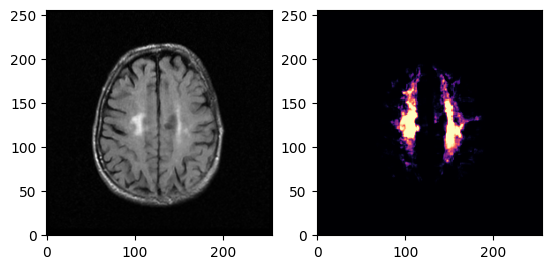

In [276]:
islice = 21
plt.subplot(1, 2, 1)
plt.imshow(sitk.GetArrayFromImage(img)[islice], cmap='gray', origin='lower')
plt.subplot(1, 2, 2)
plt.imshow(sitk.GetArrayFromImage(comb)[islice], origin='lower', cmap='magma')

In [74]:
volumes = []

for pos in tqdm(range(len(xs)), position=0, leave=True):
    ID = clin_values.iloc[pos]['ID']
    wm_path = fast_folder + ID + "_T1_BET_pve_2.nii.gz"
    result_dir = "/home/s2208943/ipdis/data/preprocessed_data/EdData_umaps/ssn/"
    
    comb_img = sitk.ReadImage(result_dir + ID + "_comb_map.nii.gz")
    array = sitk.GetArrayFromImage(comb_img)
    volumes.append(np.sum(array) * np.prod(comb_img.GetSpacing()))
    
    #break


NameError: name 'xs' is not defined

In [113]:
#np.sort(volumes, descending=True)

In [ ]:
# Note, I have found there is a one pixel line at the bottom for some of these....